## Load Packages + Original Data

In [ ]:
# standard libraries
import pandas as pd
import numpy as np
import os
import random

# visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style


# sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# tensorflow
import tensorflow as tf
from tensorflow import keras
from keras import metrics
from tensorflow.keras.callbacks import EarlyStopping
tf.get_logger().setLevel('INFO')

In [ ]:
yield_df = pd.read_csv('yield.csv')
temp_df = pd.read_csv('temp.csv')
rain_df = pd.read_csv('rainfall.csv')
# ---------------yield----------------------
# yield_df = yield_df.set_index('Year')
yield_df = yield_df.rename(columns={"Area": "country", "Value":  "Yield_hg/ha"})
yield_df = yield_df.drop(['Domain Code', 'Domain', 'Area Code', 'Element Code', 'Year Code', 'Unit', 'Element'], axis=1)
# ---------------temp-----------------------
temp_df = temp_df.rename(columns={"year": "Year"}).set_index('Year')
# ---------------rain-----------------------
rain_df = rain_df.rename(columns={" Area": "country"}).set_index('Year')


In [ ]:
# doing full outer merge to get all data in one dataframe at first
yield_temp = yield_df.merge(temp_df, how='outer', on=['Year', 'country'], suffixes=('_yield', '_temp'))
full_merge = yield_temp.merge(rain_df, how='outer', on=['Year', 'country'])
full_merge


,country,Item Code,Item,Year,Yield_hg/ha,avg_temp,average_rain_fall_mm_per_year
0,Afghanistan,56.0,Maize,1961,14000.0,14.23,NaN
1,Afghanistan,116.0,Potatoes,1961,86667.0,14.23,NaN
2,Afghanistan,27.0,"Rice, paddy",1961,15190.0,14.23,NaN
3,Afghanistan,15.0,Wheat,1961,10220.0,14.23,NaN
4,Afghanistan,56.0,Maize,1962,14000.0,14.10,NaN
...,...,...,...,...,...,...,...
169350,West Bank and Gaza,NaN,NaN,2016,NaN,NaN,402
169351,West Bank and Gaza,NaN,NaN,2017,NaN,NaN,402
169352,Yemen,NaN,NaN,2017,NaN,NaN,167
169353,Zambia,NaN,NaN,2017,NaN,NaN,1020


In [ ]:
full_merge.describe()

,Item Code,Year,Yield_hg/ha,avg_temp
count,109366.000000,169355.000000,109366.000000,140856.000000
mean,106.784494,1953.834921,65054.711099,18.059512
std,90.828406,60.994322,69140.637005,7.349943
min,15.000000,1743.000000,0.000000,-14.350000
25%,56.000000,1930.000000,16270.250000,12.280000
50%,116.000000,1976.000000,37015.500000,18.630000
75%,125.000000,1996.000000,94200.000000,25.240000
max,489.000000,2017.000000,1000000.000000,30.730000


## Data Cleaning

In [ ]:
full_merge.isna().sum()

country                               0
Item Code                         59989
Item                              59989
Year                                  0
Yield_hg/ha                       59989
avg_temp                          28499
average_rain_fall_mm_per_year    113920
dtype: int64

In [ ]:
# remove rows that are missing data

full_merge = full_merge.dropna() # based on feedback and amount of data we have, dropped all rows with nans


print(full_merge.shape)
full_merge.isna().sum()

(44135, 7)


country                          0
Item Code                        0
Item                             0
Year                             0
Yield_hg/ha                      0
avg_temp                         0
average_rain_fall_mm_per_year    0
dtype: int64

In [ ]:
full_merge.describe()

,Item Code,Year,Yield_hg/ha,avg_temp
count,44135.000000,44135.000000,44135.000000,44135.000000
mean,104.377297,1999.446380,74706.462966,19.791269
std,87.309112,8.343257,77823.478856,6.793887
min,15.000000,1985.000000,50.000000,-3.590000
25%,27.000000,1993.000000,19872.500000,15.510000
50%,116.000000,1999.000000,42526.000000,20.720000
75%,125.000000,2007.000000,107039.000000,26.120000
max,489.000000,2013.000000,501412.000000,30.650000


In [ ]:
full_merge.head()

,country,Item Code,Item,Year,Yield_hg/ha,avg_temp,average_rain_fall_mm_per_year
96,Afghanistan,56.0,Maize,1985,16652.0,15.52,327
97,Afghanistan,116.0,Potatoes,1985,140909.0,15.52,327
98,Afghanistan,27.0,"Rice, paddy",1985,22482.0,15.52,327
99,Afghanistan,15.0,Wheat,1985,12277.0,15.52,327
100,Afghanistan,56.0,Maize,1986,16875.0,14.71,327


In [ ]:
full_merge.dtypes

country                           object
Item Code                        float64
Item                              object
Year                               int64
Yield_hg/ha                      float64
avg_temp                         float64
average_rain_fall_mm_per_year     object
dtype: object

In [ ]:
full_merge.average_rain_fall_mm_per_year.unique()

array(['327', '1485', '89', '1010', '591', '562', '534', '1110', '447',
       '..', '1292', '83', '2666', '618', '847', '416', '1761', '608',
       '748', '1274', '1604', '537', '1342', '1522', '645', '3240',
       '1113', '703', '1410', '2274', '51', '1784', '2156', '383', '626',
       '536', '867', '1831', '1026', '700', '1187', '652', '1996', '1651',
       '2387', '1440', '1976', '589', '1940', '1083', '2702', '216',
       '1118', '832', '2051', '1668', '250', '630', '641', '661', '788',
       '2391', '56', '656', '1513', '1181', '2875', '282', '92', '2041',
       '758', '241', '346', '1032', '285', '1500', '778', '1732', '2280',
       '151', '1150', '1414', '494', '3142', '1738', '2348', '600', '854',
       '74', '637', '1212', '59', '686', '2526', '2497', '1162', '495',
       '636', '1712', '2331', '624', '1537', '691', '1622', '207', '593',
       '1180', '565', '78', '1220', '1300', '206', '1020', '657'],
      dtype=object)

In [ ]:
# full_merge[full_merge.average_rain_fall_mm_per_year == '..'] # these appear to just be values for the bahamas
full_merge = full_merge[full_merge.average_rain_fall_mm_per_year != '..']
full_merge.average_rain_fall_mm_per_year.unique()

array(['327', '1485', '89', '1010', '591', '562', '534', '1110', '447',
       '1292', '83', '2666', '618', '847', '416', '1761', '608', '748',
       '1274', '1604', '537', '1342', '1522', '645', '3240', '1113',
       '703', '1410', '2274', '51', '1784', '2156', '383', '626', '536',
       '867', '1831', '1026', '700', '1187', '652', '1996', '1651',
       '2387', '1440', '1976', '589', '1940', '1083', '2702', '216',
       '1118', '832', '2051', '1668', '250', '630', '641', '661', '788',
       '2391', '56', '656', '1513', '1181', '2875', '282', '92', '2041',
       '758', '241', '346', '1032', '285', '1500', '778', '1732', '2280',
       '151', '1150', '1414', '494', '3142', '1738', '2348', '600', '854',
       '74', '637', '1212', '59', '686', '2526', '2497', '1162', '495',
       '636', '1712', '2331', '624', '1537', '691', '1622', '207', '593',
       '1180', '565', '78', '1220', '1300', '206', '1020', '657'],
      dtype=object)

In [ ]:
full_merge.country.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina',
       'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas',
       'Bahrain', 'Bangladesh', 'Belarus', 'Belgium', 'Botswana',
       'Brazil', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cameroon',
       'Canada', 'Central African Republic', 'Chile', 'China', 'Colombia',
       'Croatia', 'Denmark', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana',
       'Greece', 'Guatemala', 'Guinea', 'Guyana', 'Haiti', 'Honduras',
       'Hungary', 'India', 'Indonesia', 'Iraq', 'Ireland', 'Italy',
       'Jamaica', 'Japan', 'Kazakhstan', 'Kenya', 'Latvia', 'Lebanon',
       'Lesotho', 'Liberia', 'Libya', 'Lithuania', 'Madagascar', 'Malawi',
       'Malaysia', 'Mali', 'Mauritania', 'Mauritius', 'Mexico',
       'Mongolia', 'Montenegro', 'Morocco', 'Mozambique', 'Namibia',
       'Nepal', 'Netherlands', 'New

In [ ]:
full_merge.country = full_merge.country.astype('string')
full_merge.average_rain_fall_mm_per_year = full_merge.average_rain_fall_mm_per_year.astype('float')
full_merge.dtypes

<ipython-input-175-55e7f2831c9c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_merge.country = full_merge.country.astype('string')
<ipython-input-175-55e7f2831c9c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_merge.average_rain_fall_mm_per_year = full_merge.average_rain_fall_mm_per_year.astype('float')


country                           string
Item Code                        float64
Item                              object
Year                               int64
Yield_hg/ha                      float64
avg_temp                         float64
average_rain_fall_mm_per_year    float64
dtype: object

In [ ]:
# One hot encode crop type
one_hot_encoded_data = pd.get_dummies(full_merge.drop(['Item Code'], axis=1), columns = ['Item'])
one_hot_encoded_data = one_hot_encoded_data*1

one_hot_encoded_data.head()

,country,Year,Yield_hg/ha,avg_temp,average_rain_fall_mm_per_year,Item_Cassava,Item_Maize,Item_Plantains and others,Item_Potatoes,"Item_Rice, paddy",Item_Sorghum,Item_Soybeans,Item_Sweet potatoes,Item_Wheat,Item_Yams
96,Afghanistan,1985,16652.0,15.52,327.0,0,1,0,0,0,0,0,0,0,0
97,Afghanistan,1985,140909.0,15.52,327.0,0,0,0,1,0,0,0,0,0,0
98,Afghanistan,1985,22482.0,15.52,327.0,0,0,0,0,1,0,0,0,0,0
99,Afghanistan,1985,12277.0,15.52,327.0,0,0,0,0,0,0,0,0,1,0
100,Afghanistan,1986,16875.0,14.71,327.0,0,1,0,0,0,0,0,0,0,0


In [ ]:
# One hot encode country identifications
country_info = pd.read_csv('one_hot_encoded_continent_country.csv', encoding='latin-1').drop(['Region', 'Continent'], axis=1)

country_info = country_info.rename(columns={"Country": "country"})

country_info.head()

,country,Country_Afghanistan,Country_Albania,Country_Algeria,Country_American Samoa,Country_Andorra,Country_Angola,Country_Anguilla,Country_Antarctica,Country_Antigua and Barbuda,...,Region_Western Africa,Region_Western Asia,Region_Western Europe,Continent_Africa,Continent_Antarctica,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America
0,Afghanistan,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,Åland Islands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,Albania,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,Algeria,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,American Samoa,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
one_hot_with_country = one_hot_encoded_data.merge(country_info, how='left', on='country')
one_hot_with_country.tail()

,country,Year,Yield_hg/ha,avg_temp,average_rain_fall_mm_per_year,Item_Cassava,Item_Maize,Item_Plantains and others,Item_Potatoes,"Item_Rice, paddy",...,Region_Western Africa,Region_Western Asia,Region_Western Europe,Continent_Africa,Continent_Antarctica,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America
44115,Zimbabwe,2013,22581.0,19.76,657.0,0,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
44116,Zimbabwe,2013,3066.0,19.76,657.0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
44117,Zimbabwe,2013,13142.0,19.76,657.0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
44118,Zimbabwe,2013,22222.0,19.76,657.0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
44119,Zimbabwe,2013,22888.0,19.76,657.0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


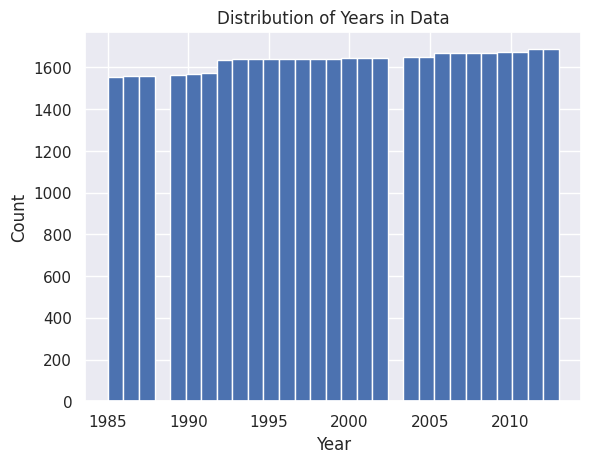

In [ ]:
hist = one_hot_encoded_data.Year.hist(bins=29)
plt.title('Distribution of Years in Data')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

## Break out train and test datasets for different models

In [ ]:
train_period = list(range(1985,2007))

test_period = list(range(2007, 2014))

In [ ]:

## baseline model ##
####################
base_model_features = ['Year']

## environmental model ##
####################
env_model_features = list(one_hot_encoded_data.columns)

## geography model ##
####################
geog_model_features = list(one_hot_with_country.columns)

print('Features in baseline model:', len(base_model_features))
print('Features in environmental model:', len(env_model_features))
print('Features in geography model:', len(geog_model_features))

Features in baseline model: 1
Features in environmental model: 15
Features in geography model: 294


In [ ]:
def train_test_data(df, model, countries, years):
    """ Create Y, X arrays, depending on model specification
    params:
    -------
    df: dataframe, cleaned init_df
    model: string, defines model of interest: 'baseline' or 'environmental'
    countries: list of strings, countries of interest
    dates: list of ints, years of interest

    return:
    ------
    y: np.array, outcome variable (this is what we are trying to predict)
    X: np.array, features corresponding to the chosen model
    mini_df: df cleaned based on arguments adm0_names and dates;
             you want to return this df because it contains additional variables (e.g., country name, date) that
             will be used to compute the performance of the model
    """
    ## keep observations only if country is in training
    mini_df = df[df.country.isin(countries)]

    ## keep observations only if date is in dates
    mini_df = mini_df[mini_df.Year.isin(years)]

    ## create dependent variable
    y = mini_df['Yield_hg/ha']

    ## create explanatory variables
    if model == "baseline":
        X = mini_df[base_model_features]

    if model == "environmental":
        X = mini_df[env_model_features]

    if model == "geography":
        X = mini_df[geog_model_features]

    return X, y, mini_df

In [ ]:
## X, y, mini_df for the baseline model ##
##########################################
print('baseline model')
print('--------------')
X_train_b, y_train_b, df_train_b = train_test_data(
    one_hot_encoded_data,
    model='baseline',
    countries=one_hot_encoded_data.country.unique(),
    years=train_period)

X_test_b, y_test_b, df_test_b = train_test_data(
    one_hot_encoded_data,
    model='baseline',
    countries=df_train_b.country.unique(),
    years=test_period)

# check shape of data
print('Shape of X_train_b', X_train_b.shape)
print('Shape of X_test_b', X_test_b.shape)

print(
    'Number of countries in train set:',
    df_train_b.country.nunique()
)

print(
    'Number of countries in test set:',
    df_test_b.country.nunique()
)

# just making sure that we have the same countries in train and test sets
set_diff_b = np.setdiff1d(
          df_train_b.country.unique(),
          df_test_b.country.unique()
      )

print(
    'Countries in train set but not in test set: ',
    set_diff_b
)

baseline model
--------------
Shape of X_train_b (32394, 1)
Shape of X_test_b (11698, 1)
Number of countries in train set: 115
Number of countries in test set: 115
Countries in train set but not in test set:  []


In [ ]:
## X, y, mini_df for the baseline model ##
##########################################
print('environmental model')
print('--------------')
X_train_e, y_train_e, df_train_e = train_test_data(
    one_hot_encoded_data,
    model='environmental',
    countries=one_hot_encoded_data.country.unique(),
    years=train_period)

X_test_e, y_test_e, df_test_e = train_test_data(
    one_hot_encoded_data,
    model='environmental',
    countries=df_train_e.country.unique(),
    years=test_period)

# check shape of data
print('Shape of X_train_b', X_train_e.shape)
print('Shape of X_test_b', X_test_e.shape)

print(
    'Number of countries in train set:',
    df_train_e.country.nunique()
)

print(
    'Number of countries in test set:',
    df_test_e.country.nunique()
)

# just making sure that we have the same countries in train and test sets
set_diff_e = np.setdiff1d(
          df_train_e.country.unique(),
          df_test_e.country.unique()
      )

print(
    'Countries in train set but not in test set: ',
    set_diff_e
)

environmental model
--------------
Shape of X_train_b (32394, 15)
Shape of X_test_b (11698, 15)
Number of countries in train set: 115
Number of countries in test set: 115
Countries in train set but not in test set:  []


In [ ]:
## X, y, mini_df for the baseline model ##
##########################################
print('geography model')
print('--------------')
X_train_g, y_train_g, df_train_g = train_test_data(
    one_hot_with_country,
    model='geography',
    countries=one_hot_with_country.country.unique(),
    years=train_period)

X_test_g, y_test_g, df_test_g = train_test_data(
    one_hot_with_country,
    model='geography',
    countries=df_train_g.country.unique(),
    years=test_period)

# check shape of data
print('Shape of X_train_b', X_train_g.shape)
print('Shape of X_test_b', X_test_g.shape)

print(
    'Number of countries in train set:',
    df_train_g.country.nunique()
)

print(
    'Number of countries in test set:',
    df_test_g.country.nunique()
)

# just making sure that we have the same countries in train and test sets
set_diff_g = np.setdiff1d(
          df_train_g.country.unique(),
          df_test_g.country.unique()
      )

print(
    'Countries in train set but not in test set: ',
    set_diff_g
)

geography model
--------------
Shape of X_train_b (32394, 294)
Shape of X_test_b (11698, 294)
Number of countries in train set: 115
Number of countries in test set: 115
Countries in train set but not in test set:  []


## EDA with Training Data

In [ ]:
df_train_b.columns

Index(['country', 'Year', 'Yield_hg/ha', 'avg_temp',
       'average_rain_fall_mm_per_year', 'Item_Cassava', 'Item_Maize',
       'Item_Plantains and others', 'Item_Potatoes', 'Item_Rice, paddy',
       'Item_Sorghum', 'Item_Soybeans', 'Item_Sweet potatoes', 'Item_Wheat',
       'Item_Yams'],
      dtype='object')

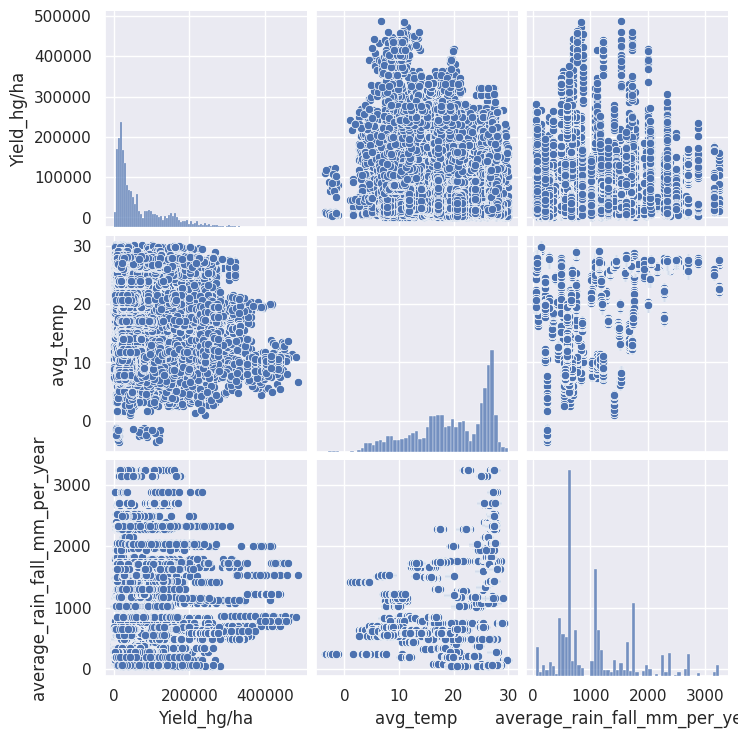

In [ ]:
variables = ['Yield_hg/ha', 'avg_temp','average_rain_fall_mm_per_year']

sns.pairplot(df_train_b[variables])
# df_train_b[variables].dtypes

In [ ]:
df_train_e[variables].corr()

,Yield_hg/ha,avg_temp,average_rain_fall_mm_per_year
Yield_hg/ha,1.000000,-0.154547,-0.032728
avg_temp,-0.154547,1.000000,0.397373
average_rain_fall_mm_per_year,-0.032728,0.397373,1.000000


In [ ]:
df_train_e.describe()

,Year,Yield_hg/ha,avg_temp,average_rain_fall_mm_per_year,Item_Cassava,Item_Maize,Item_Plantains and others,Item_Potatoes,"Item_Rice, paddy",Item_Sorghum,Item_Soybeans,Item_Sweet potatoes,Item_Wheat,Item_Yams
count,32394.000000,32394.000000,32394.000000,32394.00000,32394.000000,32394.000000,32394.000000,32394.000000,32394.000000,32394.000000,32394.000000,32394.000000,32394.000000,32394.000000
mean,1995.628728,71124.899426,19.754060,1097.92014,0.085479,0.139439,0.022967,0.142094,0.120979,0.108384,0.112953,0.107859,0.130178,0.029666
std,6.195175,73699.870514,6.775382,686.15263,0.279597,0.346410,0.149801,0.349152,0.326108,0.310870,0.316540,0.310208,0.336505,0.169667
min,1985.000000,50.000000,-3.590000,51.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1991.000000,18901.000000,15.510000,645.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1996.000000,40010.000000,20.730000,854.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2001.000000,103411.750000,26.070000,1537.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2006.000000,487219.000000,30.060000,3240.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<Axes: >

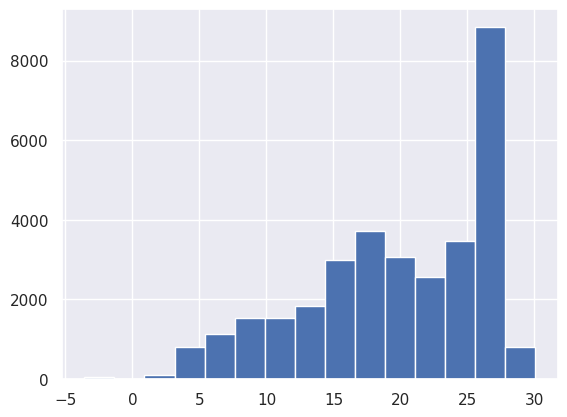

In [ ]:
df_train_e.avg_temp.hist(bins=15)

<Axes: >

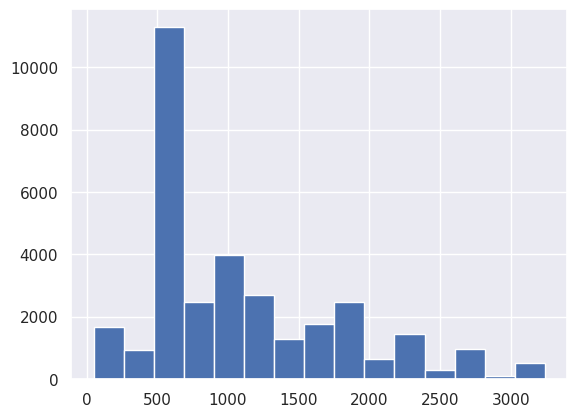

In [ ]:
df_train_e.average_rain_fall_mm_per_year.hist(bins=15)

<Axes: >

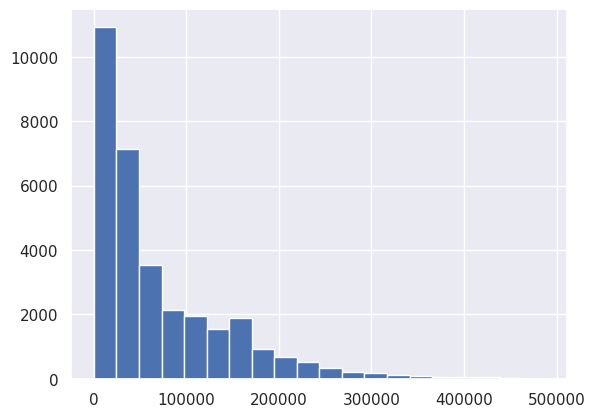

In [ ]:
df_train_e['Yield_hg/ha'].hist(bins=20)

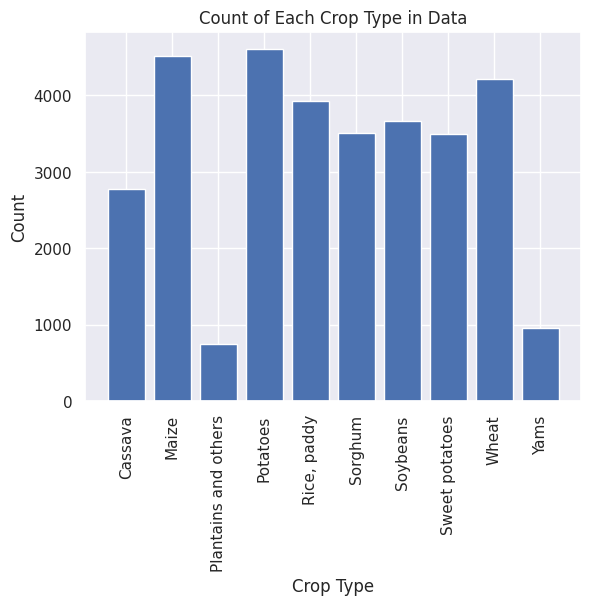

In [ ]:
df_items_only = df_train_e.filter(regex='Item')
new_cols = [x.replace('Item_', '') for x in df_items_only.columns]
df_items_only.columns = new_cols
df_crop_counts = pd.DataFrame(df_items_only.sum().reset_index())

df_crop_counts.rename(columns={'index': 'crop', 0: 'quantity'}, inplace=True)


plt.bar(df_crop_counts.crop, df_crop_counts.quantity)
plt.title('Count of Each Crop Type in Data')
plt.xlabel('Crop Type')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

## Normalize numeric features

In [ ]:
# create copies of the features dataframes to normalize
norm_variables = ['avg_temp','average_rain_fall_mm_per_year', 'Yield_hg/ha']
df_train_e_norm = df_train_e.copy()
df_test_e_norm = df_test_e.copy()

df_train_g_norm = df_train_g.copy()
df_test_g_norm = df_test_g.copy()

for column in norm_variables:
    # normalize values in each column by the mean and std dev of the training data
    df_train_e_norm[column] = (df_train_e_norm[column] -
                           df_train_e_norm[column].mean()) / df_train_e_norm[column].std()
    # normalize test features with mean and std dev of the training data to maintain blindness of the test data
    df_test_e_norm[column] = (df_test_e_norm[column] -
                           df_train_e[column].mean()) / df_train_e[column].std()
    # normalize values in each column by the mean and std dev of the training data
    df_train_g_norm[column] = (df_train_g_norm[column] -
                           df_train_g_norm[column].mean()) / df_train_g_norm[column].std()
    # normalize test features with mean and std dev of the training data to maintain blindness of the test data
    df_test_g_norm[column] = (df_test_g_norm[column] -
                           df_train_g[column].mean()) / df_train_g[column].std()

# verify data has been normalized - want mean 0 and std dev 1
df_train_e_norm.describe()

,Year,Yield_hg/ha,avg_temp,average_rain_fall_mm_per_year,Item_Cassava,Item_Maize,Item_Plantains and others,Item_Potatoes,"Item_Rice, paddy",Item_Sorghum,Item_Soybeans,Item_Sweet potatoes,Item_Wheat,Item_Yams
count,32394.000000,3.239400e+04,3.239400e+04,3.239400e+04,32394.000000,32394.000000,32394.000000,32394.000000,32394.000000,32394.000000,32394.000000,32394.000000,32394.000000,32394.000000
mean,1995.628728,-9.826608e-17,1.544181e-16,-1.754751e-16,0.085479,0.139439,0.022967,0.142094,0.120979,0.108384,0.112953,0.107859,0.130178,0.029666
std,6.195175,1.000000e+00,1.000000e+00,1.000000e+00,0.279597,0.346410,0.149801,0.349152,0.326108,0.310870,0.316540,0.310208,0.336505,0.169667
min,1985.000000,-9.643830e-01,-3.445424e+00,-1.525783e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1991.000000,-7.086023e-01,-6.263942e-01,-6.600866e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1996.000000,-4.221839e-01,1.440421e-01,-3.554896e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2001.000000,4.380856e-01,9.321895e-01,6.399157e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2006.000000,5.645791e+00,1.521086e+00,3.121871e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df_train_g_norm.describe()

,Year,Yield_hg/ha,avg_temp,average_rain_fall_mm_per_year,Item_Cassava,Item_Maize,Item_Plantains and others,Item_Potatoes,"Item_Rice, paddy",Item_Sorghum,...,Region_Western Africa,Region_Western Asia,Region_Western Europe,Continent_Africa,Continent_Antarctica,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America
count,32394.000000,3.239400e+04,3.239400e+04,3.239400e+04,32394.000000,32394.000000,32394.000000,32394.000000,32394.000000,32394.000000,...,32194.000000,32194.000000,32194.000000,32194.000000,32194.0,32194.000000,32194.000000,32194.000000,32194.000000,32194.000000
mean,1995.628728,-9.826608e-17,1.544181e-16,-1.754751e-16,0.085479,0.139439,0.022967,0.142094,0.120979,0.108384,...,0.082282,0.040784,0.017923,0.207430,0.0,0.460365,0.081133,0.095856,0.032988,0.122228
std,6.195175,1.000000e+00,1.000000e+00,1.000000e+00,0.279597,0.346410,0.149801,0.349152,0.326108,0.310870,...,0.274799,0.197793,0.132672,0.405472,0.0,0.498434,0.273044,0.294399,0.178607,0.327554
min,1985.000000,-9.643830e-01,-3.445424e+00,-1.525783e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1991.000000,-7.086023e-01,-6.263942e-01,-6.600866e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1996.000000,-4.221839e-01,1.440421e-01,-3.554896e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2001.000000,4.380856e-01,9.321895e-01,6.399157e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000
max,2006.000000,5.645791e+00,1.521086e+00,3.121871e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000


<Axes: >

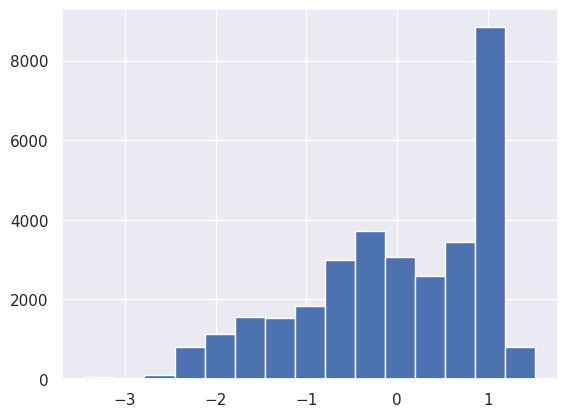

In [ ]:
df_train_e_norm.avg_temp.hist(bins=15)

In [ ]:
df_train_e.head()

,country,Year,Yield_hg/ha,avg_temp,average_rain_fall_mm_per_year,Item_Cassava,Item_Maize,Item_Plantains and others,Item_Potatoes,"Item_Rice, paddy",Item_Sorghum,Item_Soybeans,Item_Sweet potatoes,Item_Wheat,Item_Yams
96,Afghanistan,1985,16652.0,15.52,327.0,0,1,0,0,0,0,0,0,0,0
97,Afghanistan,1985,140909.0,15.52,327.0,0,0,0,1,0,0,0,0,0,0
98,Afghanistan,1985,22482.0,15.52,327.0,0,0,0,0,1,0,0,0,0,0
99,Afghanistan,1985,12277.0,15.52,327.0,0,0,0,0,0,0,0,0,1,0
100,Afghanistan,1986,16875.0,14.71,327.0,0,1,0,0,0,0,0,0,0,0


In [ ]:
df_train_e.describe()

,Year,Yield_hg/ha,avg_temp,average_rain_fall_mm_per_year,Item_Cassava,Item_Maize,Item_Plantains and others,Item_Potatoes,"Item_Rice, paddy",Item_Sorghum,Item_Soybeans,Item_Sweet potatoes,Item_Wheat,Item_Yams
count,32394.000000,32394.000000,32394.000000,32394.00000,32394.000000,32394.000000,32394.000000,32394.000000,32394.000000,32394.000000,32394.000000,32394.000000,32394.000000,32394.000000
mean,1995.628728,71124.899426,19.754060,1097.92014,0.085479,0.139439,0.022967,0.142094,0.120979,0.108384,0.112953,0.107859,0.130178,0.029666
std,6.195175,73699.870514,6.775382,686.15263,0.279597,0.346410,0.149801,0.349152,0.326108,0.310870,0.316540,0.310208,0.336505,0.169667
min,1985.000000,50.000000,-3.590000,51.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1991.000000,18901.000000,15.510000,645.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1996.000000,40010.000000,20.730000,854.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2001.000000,103411.750000,26.070000,1537.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2006.000000,487219.000000,30.060000,3240.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
one_hot_with_country

,country,Year,Yield_hg/ha,avg_temp,average_rain_fall_mm_per_year,Item_Cassava,Item_Maize,Item_Plantains and others,Item_Potatoes,"Item_Rice, paddy",...,Region_Western Africa,Region_Western Asia,Region_Western Europe,Continent_Africa,Continent_Antarctica,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America
0,Afghanistan,1985,16652.0,15.52,327.0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,Afghanistan,1985,140909.0,15.52,327.0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,Afghanistan,1985,22482.0,15.52,327.0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,Afghanistan,1985,12277.0,15.52,327.0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,Afghanistan,1986,16875.0,14.71,327.0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44115,Zimbabwe,2013,22581.0,19.76,657.0,0,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
44116,Zimbabwe,2013,3066.0,19.76,657.0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
44117,Zimbabwe,2013,13142.0,19.76,657.0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
44118,Zimbabwe,2013,22222.0,19.76,657.0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_train_g_norm

,country,Year,Yield_hg/ha,avg_temp,average_rain_fall_mm_per_year,Item_Cassava,Item_Maize,Item_Plantains and others,Item_Potatoes,"Item_Rice, paddy",...,Region_Western Africa,Region_Western Asia,Region_Western Europe,Continent_Africa,Continent_Antarctica,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America
0,Afghanistan,1985,-0.739118,-0.624918,-1.123540,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,Afghanistan,1985,0.946869,-0.624918,-1.123540,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,Afghanistan,1985,-0.660013,-0.624918,-1.123540,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,Afghanistan,1985,-0.798480,-0.624918,-1.123540,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,Afghanistan,1986,-0.736092,-0.744469,-1.123540,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44059,Zimbabwe,2006,-0.639416,0.139614,-0.642598,0,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
44060,Zimbabwe,2006,-0.909552,0.139614,-0.642598,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
44061,Zimbabwe,2006,-0.762782,0.139614,-0.642598,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
44062,Zimbabwe,2006,-0.672401,0.139614,-0.642598,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Save datasets to CSV

In [ ]:
df_train_e.to_csv('training_e.csv')
df_test_e.to_csv('test_e.csv')
df_train_e_norm.to_csv('training_normalized_e.csv')
df_test_e_norm.to_csv('test_normalized_e.csv')

df_train_g.to_csv('training_g.csv')
df_test_g.to_csv('test_g.csv')
df_train_g_norm.to_csv('training_normalized_g.csv')
df_test_g_norm.to_csv('test_normalized_g.csv')

## Baseline that always predicts the average yield

In [ ]:
from sklearn.model_selection import train_test_split

training_data = pd.read_csv('training_normalized_g.csv', index_col=0)
# training_data.head()
train_Y = training_data['Yield_hg/ha']
train_X = training_data.drop(['Yield_hg/ha'], axis=1)
train_X_norm = pd.read_csv('training_normalized_e.csv', index_col=0)

train_X['Year'][:5]

# create a train/validation split
X_train, X_val, y_train, y_val = train_test_split(train_X, train_Y, train_size=0.8)

#confirm data shapes
print(train_Y.shape,
train_X.shape,
X_train.shape,
X_val.shape,
y_train.shape,
y_val.shape)

(32394,) (32394, 293) (25915, 293) (6479, 293) (25915,) (6479,)


In [ ]:
def baseline_v2(x_input):
    avg_yield = y_train.mean()
    return np.full((len(x_input),), avg_yield)

In [ ]:
# compute RMSE on train data
from sklearn.metrics import mean_squared_error
predictions_train = baseline_v2(X_train)
m = len(X_train)
diff_train = np.subtract(predictions_train, y_train)
rmse_train = np.sqrt((np.sum(np.square(diff_train)))/m)
print('RMSE baseline on train data: ', rmse_train)
print('-'*10)

# compute RMSE on test data
predictions_val = baseline_v2(y_val)
n = len(y_val)
diff_val = np.subtract(predictions_val, y_val)
rmse_val = np.sqrt((np.sum(np.square(diff_val)))/n)
print('RMSE baseline on val data: ', rmse_val)
mse = mean_squared_error(y_val, predictions_val)
print('MSE baseline on val data: ', mse)

RMSE baseline on train data:  1.0002673893753449
----------
RMSE baseline on val data:  0.9988578785508117
MSE baseline on val data:  0.997717061543028


# Model Setup

In [ ]:
## linear regression - year and crop yield

def build_baseline_model(num_features, learning_rate):
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

        # Build a model using keras.Sequential. While this is intended for neural
        # networks (which may have multiple layers), we want just a single layer for
        # linear regression.
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(
          units=1,                     # output dim
          input_shape=[num_features],  # input dim
          use_bias=True,               # use a bias (intercept) param
          kernel_initializer=tf.ones_initializer,  # initialize params to 1
          bias_initializer=tf.ones_initializer,    # initialize bias to 1
      ))

      # We need to choose an optimizer. We'll use SGD, which is actually mini-batch
      # SGD. We can specify the batch size to use for training later.
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

      # Finally, we compile the model. This finalizes the graph for training.
      # We specify the MSE loss.
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [ ]:
from sklearn.model_selection import train_test_split

training_data = pd.read_csv('training_e.csv', index_col=0)
# training_data.head()
train_Y = training_data['Yield_hg/ha']
train_X = training_data.drop(['Yield_hg/ha'], axis=1)
train_X_norm = pd.read_csv('training_normalized_e.csv', index_col=0)

train_X['Year'][:5]

# create a train/validation split
X_train, X_val, y_train, y_val = train_test_split(train_X, train_Y, train_size=0.8)

#confirm data shapes
print(train_Y.shape,
train_X.shape,
X_train.shape,
X_val.shape,
y_train.shape,
y_val.shape)

(32394,) (32394, 14) (25915, 14) (6479, 14) (25915,) (6479,)


In [ ]:
#baseline with normalized geographical data
from sklearn.model_selection import train_test_split

training_data = pd.read_csv('training_normalized_g.csv', index_col=0)
# training_data.head()
train_Y = training_data['Yield_hg/ha']
train_X = training_data.drop(['Yield_hg/ha'], axis=1)
train_X_norm = pd.read_csv('training_normalized_e.csv', index_col=0)

train_X['Year'][:5]

# create a train/validation split
X_train, X_val, y_train, y_val = train_test_split(train_X, train_Y, train_size=0.8)

#confirm data shapes
print(train_Y.shape,
train_X.shape,
X_train.shape,
X_val.shape,
y_train.shape,
y_val.shape)

(32394,) (32394, 293) (25915, 293) (6479, 293) (25915,) (6479,)


Weights: [[1.]]
Biases: [1.]
Epoch 1/10
912/912 [==============================] - 2s 2ms/step - loss: 2.9093 - val_loss: 2.7777
Epoch 2/10
912/912 [==============================] - 2s 2ms/step - loss: 2.2756 - val_loss: 2.4343
Epoch 3/10
912/912 [==============================] - 2s 2ms/step - loss: 1.8424 - val_loss: 2.1943
Epoch 4/10
912/912 [==============================] - 2s 2ms/step - loss: 1.5466 - val_loss: 2.0255
Epoch 5/10
912/912 [==============================] - 2s 2ms/step - loss: 1.3441 - val_loss: 1.9067
Epoch 6/10
912/912 [==============================] - 2s 2ms/step - loss: 1.2060 - val_loss: 1.8222
Epoch 7/10
912/912 [==============================] - 2s 2ms/step - loss: 1.1115 - val_loss: 1.7622
Epoch 8/10
912/912 [==============================] - 2s 2ms/step - loss: 1.0472 - val_loss: 1.7189
Epoch 9/10
912/912 [==============================] - 2s 2ms/step - loss: 1.0030 - val_loss: 1.6876
Epoch 10/10
912/912 [==============================] - 2s 2ms/step - lo

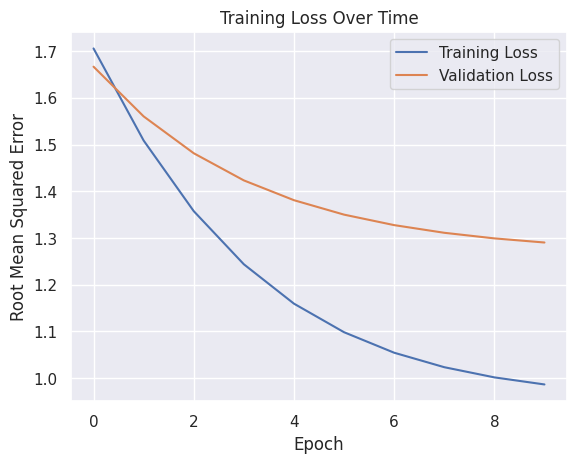

Final train loss: 0.9729207158088684
Final weights: [array([[0.02978965]], dtype=float32), array([0.14681002], dtype=float32)]
Final validation loss: 1.6647059917449951
Test rmse: 1.0034775467980315
Test mse 1.0069671869277954


In [ ]:
#LR with average temp as feature
baseline_model = build_baseline_model(num_features=1, learning_rate=0.0001)

# Use get_weights() which returns lists of weights and biases for the layer.
weights, biases = baseline_model.layers[0].get_weights()
print('Weights:', weights)
print('Biases:', biases)

baseline_history = baseline_model.fit(
  x = train_X[['avg_temp']],
  y = train_Y,
  validation_split=0.1,  # use 10% of the examples as a validation set
  epochs=10,
  batch_size=32,
  verbose=1)

# Convert the return value into a DataFrame so we can see the loss after each
# epoch. The history includes training data loss ('loss') and validation data
# loss ('val_loss').
#baseline_history = pd.DataFrame(baseline_history.history)
#display(baseline_history)

plt.plot(np.sqrt(baseline_history.history['loss']), label='Training Loss')
plt.plot(np.sqrt(baseline_history.history['val_loss']), label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Squared Error')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

print('Final train loss:', list(baseline_history.history['loss'])[-1])
print('Final weights:', baseline_model.layers[0].get_weights())
print('Final validation loss:', list(baseline_history.history['val_loss'])[-1])

# Make predictions on test data
test_loss = baseline_model.evaluate(X_val['avg_temp'],
                             y_val,
                             verbose=0)
test_rmse = np.sqrt(test_loss)
test_mse = test_loss
print('Test rmse:', test_rmse)
print('Test mse', test_mse)

Weights: [[1.]]
Biases: [1.]
Epoch 1/10
912/912 [==============================] - 3s 2ms/step - loss: 2.7653 - val_loss: 2.1065
Epoch 2/10
912/912 [==============================] - 2s 2ms/step - loss: 2.1768 - val_loss: 1.9287
Epoch 3/10
912/912 [==============================] - 2s 2ms/step - loss: 1.7760 - val_loss: 1.8139
Epoch 4/10
912/912 [==============================] - 2s 2ms/step - loss: 1.5039 - val_loss: 1.7406
Epoch 5/10
912/912 [==============================] - 2s 2ms/step - loss: 1.3186 - val_loss: 1.6949
Epoch 6/10
912/912 [==============================] - 2s 2ms/step - loss: 1.1930 - val_loss: 1.6671
Epoch 7/10
912/912 [==============================] - 2s 2ms/step - loss: 1.1074 - val_loss: 1.6510
Epoch 8/10
912/912 [==============================] - 2s 2ms/step - loss: 1.0493 - val_loss: 1.6424
Epoch 9/10
912/912 [==============================] - 2s 2ms/step - loss: 1.0098 - val_loss: 1.6384
Epoch 10/10
912/912 [==============================] - 1s 2ms/step - lo

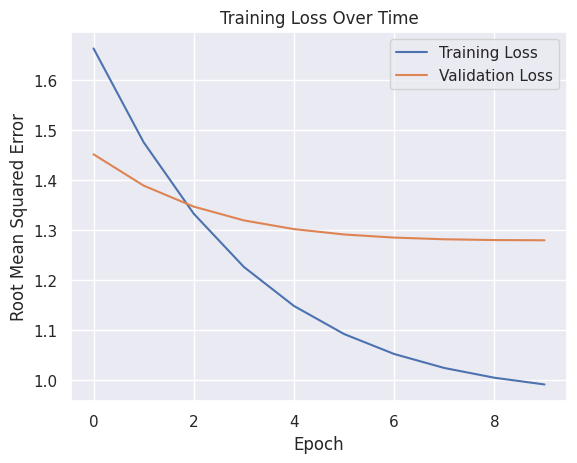

Final train loss: 0.9829596877098083
Final weights: [array([[0.10570846]], dtype=float32), array([0.14487076], dtype=float32)]
Final validation loss: 1.6372994184494019
Test rmse: 1.0047924123422882
Test mse 1.0096077919006348


In [ ]:
#LR with average rainfall as feature
baseline_model = build_baseline_model(num_features=1, learning_rate=0.0001)

# Use get_weights() which returns lists of weights and biases for the layer.
weights, biases = baseline_model.layers[0].get_weights()
print('Weights:', weights)
print('Biases:', biases)

baseline_history = baseline_model.fit(
  x = train_X[['average_rain_fall_mm_per_year']],
  y = train_Y,
  validation_split=0.1,  # use 10% of the examples as a validation set
  epochs=10,
  batch_size=32,
  verbose=1)

# Convert the return value into a DataFrame so we can see the loss after each
# epoch. The history includes training data loss ('loss') and validation data
# loss ('val_loss').
#baseline_history = pd.DataFrame(baseline_history.history)
#display(baseline_history)

plt.plot(np.sqrt(baseline_history.history['loss']), label='Training Loss')
plt.plot(np.sqrt(baseline_history.history['val_loss']), label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Squared Error')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

print('Final train loss:', list(baseline_history.history['loss'])[-1])
print('Final weights:', baseline_model.layers[0].get_weights())
print('Final validation loss:', list(baseline_history.history['val_loss'])[-1])

# Make predictions on test data
test_loss = baseline_model.evaluate(X_val['average_rain_fall_mm_per_year'],
                             y_val,
                             verbose=0)
test_rmse = np.sqrt(test_loss)
test_mse = test_loss
print('Test rmse:', test_rmse)
print('Test mse', test_mse)

Weights: [[1.]
 [1.]]
Biases: [1.]
Epoch 1/10
912/912 [==============================] - 2s 2ms/step - loss: 4.3808 - val_loss: 2.9872
Epoch 2/10
912/912 [==============================] - 2s 2ms/step - loss: 3.0265 - val_loss: 2.4494
Epoch 3/10
912/912 [==============================] - 2s 2ms/step - loss: 2.2044 - val_loss: 2.1252
Epoch 4/10
912/912 [==============================] - 2s 2ms/step - loss: 1.7056 - val_loss: 1.9274
Epoch 5/10
912/912 [==============================] - 2s 2ms/step - loss: 1.4006 - val_loss: 1.8063
Epoch 6/10
912/912 [==============================] - 2s 3ms/step - loss: 1.2142 - val_loss: 1.7309
Epoch 7/10
912/912 [==============================] - 2s 2ms/step - loss: 1.0993 - val_loss: 1.6837
Epoch 8/10
912/912 [==============================] - 2s 2ms/step - loss: 1.0284 - val_loss: 1.6535
Epoch 9/10
912/912 [==============================] - 2s 2ms/step - loss: 0.9842 - val_loss: 1.6341
Epoch 10/10
912/912 [==============================] - 1s 2ms/ste

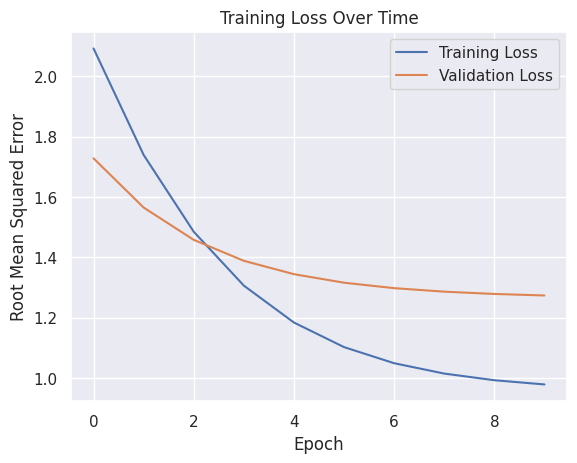

Final train loss: 0.9565067291259766
Final weights: [array([[-0.04367566],
       [ 0.05785767]], dtype=float32), array([0.14276862], dtype=float32)]
Final validation loss: 1.6212589740753174
Test rmse: 0.9941202997254572
Test mse 0.9882751703262329


In [ ]:
#LR with average temp and average rainfall as features
baseline_model = build_baseline_model(num_features=2, learning_rate=0.0001)

# Use get_weights() which returns lists of weights and biases for the layer.
weights, biases = baseline_model.layers[0].get_weights()
print('Weights:', weights)
print('Biases:', biases)

baseline_history = baseline_model.fit(
  x = train_X[['avg_temp','average_rain_fall_mm_per_year']],
  y = train_Y,
  validation_split=0.1,  # use 10% of the examples as a validation set
  epochs=10,
  batch_size=32,
  verbose=1)

# Convert the return value into a DataFrame so we can see the loss after each
# epoch. The history includes training data loss ('loss') and validation data
# loss ('val_loss').
#baseline_history = pd.DataFrame(baseline_history.history)
#display(baseline_history)

plt.plot(np.sqrt(baseline_history.history['loss']), label='Training Loss')
plt.plot(np.sqrt(baseline_history.history['val_loss']), label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Squared Error')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

print('Final train loss:', list(baseline_history.history['loss'])[-1])
print('Final weights:', baseline_model.layers[0].get_weights())
print('Final validation loss:', list(baseline_history.history['val_loss'])[-1])

# Make predictions on test data
test_loss = baseline_model.evaluate(X_val[['avg_temp','average_rain_fall_mm_per_year']],
                             y_val,
                             verbose=0)
test_rmse = np.sqrt(test_loss)
test_mse = test_loss
print('Test rmse:', test_rmse)
print('Test mse', test_mse)

## Model #2 - Random Forest

In [ ]:
#normalized geographical data
from sklearn.model_selection import train_test_split

training_data = pd.read_csv('training_normalized_g.csv', index_col=0)
# training_data.head()
train_Y = training_data['Yield_hg/ha']
train_X = training_data.drop(['Yield_hg/ha'], axis=1)
train_X_norm = pd.read_csv('training_normalized_e.csv', index_col=0)

train_X['Year'][:5]

# create a train/validation split
X_train, X_val, y_train, y_val = train_test_split(train_X, train_Y, train_size=0.8)

#confirm data shapes
print(train_Y.shape,
train_X.shape,
X_train.shape,
X_val.shape,
y_train.shape,
y_val.shape)

(32394,) (32394, 293) (25915, 293) (6479, 293) (25915,) (6479,)


In [ ]:
## Model #2.1 - random forest - all variables and crop yield with geographical data all features
from sklearn.metrics import mean_squared_error
X_val_rf = X_val.fillna(0)
X_train_rf = X_train.fillna(0)

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 500, max_depth = 30, max_features = 292, random_state=0)
rf_fit = rf.fit(X_train_rf.drop(['country'], axis=1), y_train)
rf_predictions = rf_fit.predict(X_val_rf.drop(['country'], axis=1))
mse = mean_squared_error(y_val, rf_predictions)
print('MSE: ', mse)
rmse = mean_squared_error(y_val, rf_predictions, squared=False)
print('RMSE: ', rmse)

MSE:  0.010186069800077161
RMSE:  0.10092606105499789


Text(0, 0.5, 'Predicted Crop Yield')

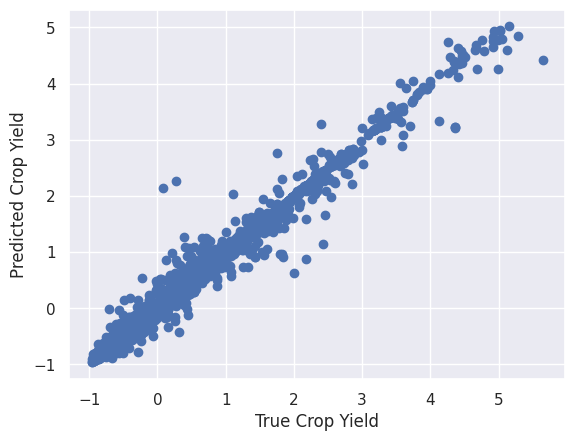

In [ ]:
plt.scatter(y_val, rf_predictions)
#include axis labels
plt.xlabel('True Crop Yield')
plt.ylabel("Predicted Crop Yield")

In [ ]:
X_train_rf.shape

(25915, 293)

In [ ]:
## Model #2.2 - random forest - all variables and crop yield with important features and hyperparameters
X_val_rf = X_val.fillna(0)
X_train_rf = X_train.fillna(0)
important_features = ['Item_Potatoes', 'Item_Cassava', 'Item_Sweet potatoes', 'average_rain_fall_mm_per_year',
                      'Region_Eastern Asia', 'Region_Western Europe', 'Year', 'avg_temp', 'Item_Yams',
                      'Country_India', 'Item_Plantains and others', 'Country_Japan', 'Region_Australia and New Zealand',
                      'Country_China', 'Country_Guatemala', 'Country_Nigeria', 'Region_Eastern Africa', 'Continent_Africa']

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 500, max_depth = 20, max_features = 18, min_samples_leaf = 1, random_state=0)
rf_fit = rf.fit(X_train_rf[important_features], y_train)
rf_predictions = rf_fit.predict(X_val_rf[important_features])
mse = mean_squared_error(y_val, rf_predictions)
print('MSE: ', mse)
rmse = mean_squared_error(y_val, rf_predictions, squared=False)
print('RMSE: ', rmse)

MSE:  0.04204100931148481
RMSE:  0.2050390433831684


In [ ]:
print(y_train.mean())
print(y_train.median())

-0.0006270812414175597
-0.4223195944409075


Text(0, 0.5, 'Predicted Crop Yield')

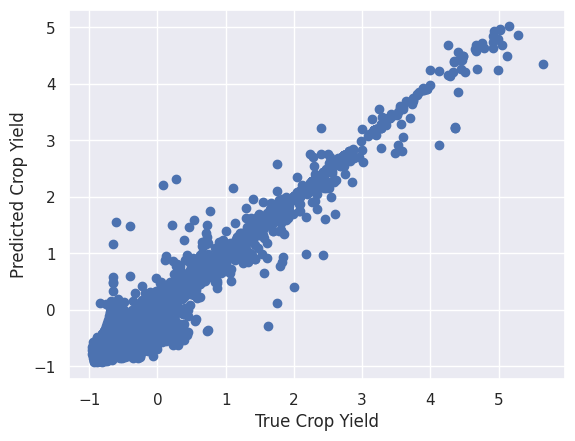

In [ ]:
plt.scatter(y_val, rf_predictions)
#include axis labels
plt.xlabel('True Crop Yield')
plt.ylabel("Predicted Crop Yield")

In [ ]:
#pd.Series(rf_fit.feature_importances_).plot.bar()
importances = list(rf.feature_importances_)
x_values = list(range(len(importances)))
feature_list = list(X_train_rf.drop(['country'],axis = 1).columns)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

#plt.figure(figsize = (10,5))
#plt.bar(x_values, importances, orientation = 'vertical')
#plt.xticks(x_values, feature_list, rotation='vertical')


Variable: Year                 Importance: 0.31
Variable: average_rain_fall_mm_per_year Importance: 0.13
Variable: Item_Cassava         Importance: 0.13
Variable: avg_temp             Importance: 0.12
Variable: Item_Rice, paddy     Importance: 0.05
Variable: Item_Maize           Importance: 0.04
Variable: Item_Plantains and others Importance: 0.03
Variable: Item_Potatoes        Importance: 0.03
Variable: Item_Sorghum         Importance: 0.03
Variable: Item_Soybeans        Importance: 0.03
Variable: Item_Sweet potatoes  Importance: 0.02
Variable: Item_Wheat           Importance: 0.02
Variable: Item_Yams            Importance: 0.02
Variable: Country_Andorra      Importance: 0.02
Variable: Country_Afghanistan  Importance: 0.01
Variable: Country_Albania      Importance: 0.01
Variable: Country_Algeria      Importance: 0.01
Variable: Country_American Samoa Importance: 0.0


In [ ]:
## Model #2.3 - random forest - all variables and crop yield with important features and hyperparameters
X_val_rf = X_val.fillna(0)
X_train_rf = X_train.fillna(0)
important_features = ['Year', 'avg_temp', 'average_rain_fall_mm_per_year', 'Item_Cassava', 'Item_Maize',
                      'Item_Rice, paddy', 'Item_Plantains and others', 'Item_Potatoes', 'Item_Sorghum',
                      'Item_Soybeans', 'Item_Sweet potatoes', 'Item_Wheat','Item_Yams','Country_Andorra',
                      'Country_Afghanistan', 'Country_Albania', 'Country_Algeria']

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 500, max_depth = 20, max_features = 17, min_samples_leaf = 1, random_state=0)
rf_fit = rf.fit(X_train_rf[important_features], y_train)
rf_predictions = rf_fit.predict(X_val_rf[important_features])
mse = mean_squared_error(y_val, rf_predictions)
print('MSE: ', mse)
rmse = mean_squared_error(y_val, rf_predictions, squared=False)
print('RMSE: ', rmse)

MSE:  0.016300404027515477
RMSE:  0.1276730356321


## Model 3 -- Neural Network -- All variables and crop yield
**PRE-STANDARDIZATION**

Epoch 1/5
810/810 [==============================] - 4s 4ms/step - loss: 6512098304.0000 - val_loss: 6228595712.0000
Epoch 2/5
810/810 [==============================] - 2s 2ms/step - loss: 5820983808.0000 - val_loss: 6096520704.0000
Epoch 3/5
810/810 [==============================] - 2s 2ms/step - loss: 5695986176.0000 - val_loss: 5889498112.0000
Epoch 4/5
810/810 [==============================] - 2s 2ms/step - loss: 5579828736.0000 - val_loss: 6515284992.0000
Epoch 5/5
366/366 [==============================] - 1s 1ms/step
Mean Squared Error: 8275054665.2108965


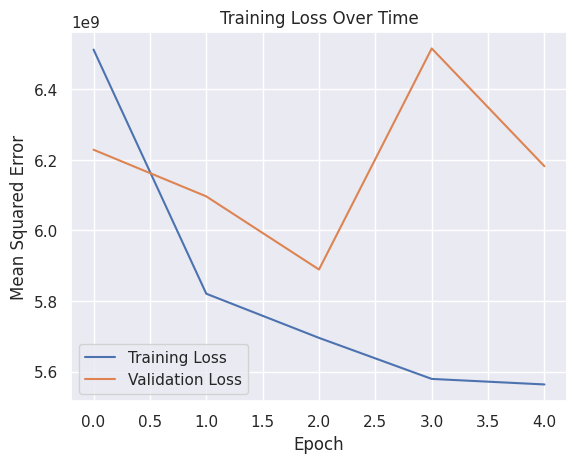

In [ ]:
#TRAIN SET
df_train = pd.read_csv('training_e.csv') #Enviornmental data set

#'Yield_hg/ha'
X_train = df_train.drop(['Yield_hg/ha', 'country'], axis=1)
y_train = df_train['Yield_hg/ha']

#TEST SET
df_test = pd.read_csv('test_e.csv')

#'Yield_hg/ha'
X_test = df_test.drop(['Yield_hg/ha', 'country'], axis=1)
y_test = df_test['Yield_hg/ha']

#NN & HYPER PARAMETERS
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='linear')
])

#LEARNING RATE
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mean_squared_error')

# TRAIN
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

# EVALUATE
predictions = model.predict(X_test)

# MSE
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

# VISUALIZE TRAINING LOSS
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

Adjusted hyper parameters and complexity

Epoch 1/100
405/405 [==============================] - 2s 3ms/step - loss: 10533666816.0000 - val_loss: 10110550016.0000
Epoch 2/100
405/405 [==============================] - 2s 4ms/step - loss: 10462059520.0000 - val_loss: 10042322944.0000
Epoch 3/100
405/405 [==============================] - 2s 5ms/step - loss: 10384537600.0000 - val_loss: 9974402048.0000
Epoch 4/100
405/405 [==============================] - 1s 4ms/step - loss: 10305703936.0000 - val_loss: 9898755072.0000
Epoch 5/100
405/405 [==============================] - 1s 3ms/step - loss: 10221284352.0000 - val_loss: 9826398208.0000
Epoch 6/100
405/405 [==============================] - 1s 3ms/step - loss: 10141051904.0000 - val_loss: 9756169216.0000
Epoch 7/100
405/405 [==============================] - 1s 3ms/step - loss: 10063650816.0000 - val_loss: 9687574528.0000
Epoch 8/100
405/405 [==============================] - 1s 3ms/step - loss: 9971939328.0000 - val_loss: 9596846080.0000
Epoch 9/100
405/405 [==================

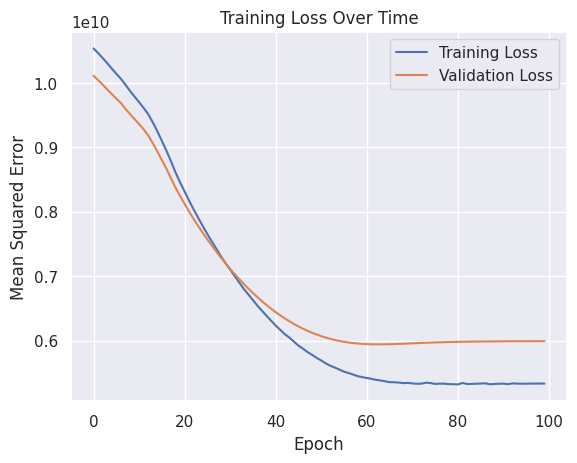

In [ ]:
#TRAIN SET
df_train = pd.read_csv('training_e.csv')

#'Yield_hg/ha'
X_train = df_train.drop(['Yield_hg/ha', 'country'], axis=1)
y_train = df_train['Yield_hg/ha']

#TEST SET
df_test = pd.read_csv('test_e.csv')

#'Yield_hg/ha'
X_test = df_test.drop(['Yield_hg/ha', 'country'], axis=1)
y_test = df_test['Yield_hg/ha']

#NN & HYPER PARAMETERS
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='sigmoid', kernel_initializer='he_normal', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='sigmoid', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='sigmoid', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='linear')
])

#LEARNING RATE
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss='mean_squared_error')

# TRAIN
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)

# EVALUATE
predictions = model.predict(X_test)

# MSE
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

# VISUALIZE TRAINING LOSS
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

**STANDARDIZATION** and correcting MSE

Epoch 1/100
405/405 [==============================] - 2s 3ms/step - loss: 1.0588 - val_loss: 1.0987
Epoch 2/100
405/405 [==============================] - 1s 3ms/step - loss: 0.9831 - val_loss: 1.0975
Epoch 3/100
405/405 [==============================] - 1s 3ms/step - loss: 0.9820 - val_loss: 1.1110
Epoch 4/100
405/405 [==============================] - 1s 3ms/step - loss: 0.9840 - val_loss: 1.1239
Epoch 5/100
405/405 [==============================] - 1s 3ms/step - loss: 0.9900 - val_loss: 1.1019
Epoch 6/100
405/405 [==============================] - 1s 3ms/step - loss: 0.9900 - val_loss: 1.1246
Epoch 7/100
405/405 [==============================] - 1s 3ms/step - loss: 0.9930 - val_loss: 1.1027
Epoch 8/100
405/405 [==============================] - 1s 3ms/step - loss: 0.9922 - val_loss: 1.1050
Epoch 9/100
405/405 [==============================] - 1s 3ms/step - loss: 0.9916 - val_loss: 1.0951
Epoch 10/100
405/405 [==============================] - 2s 4ms/step - loss: 0.9912 - val_lo

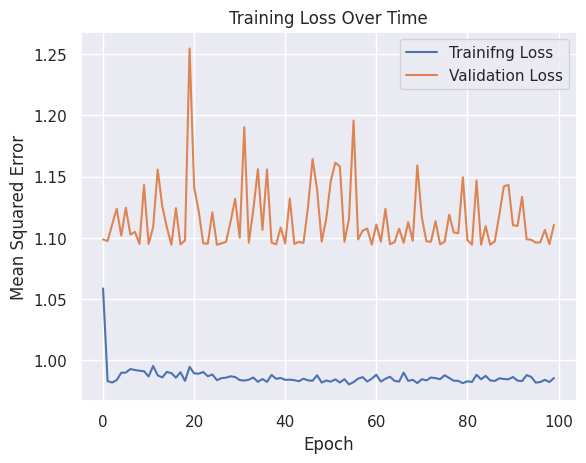

In [ ]:
# NORMALIZED TRAIN SET
df_train = pd.read_csv('training_normalized_e.csv')

# 'Yield_hg/ha' TARGET
X_train = df_train.drop(['Yield_hg/ha', 'country'], axis=1)
y_train = df_train['Yield_hg/ha']

# NORMALIZED TEST SET
df_test = pd.read_csv('test_normalized_e.csv')

# 'Yield_hg/ha' TARGET
X_test = df_test.drop(['Yield_hg/ha', 'country'], axis=1)
y_test = df_test['Yield_hg/ha']

# STANDARD, REMOVE NON-NUMERIC VALUES
numeric_cols = X_train.select_dtypes(include=['float64']).columns
scaler = StandardScaler() #Preprocessing to standardize features
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# NN & HYPER PARAMETERS
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='sigmoid', kernel_initializer='he_normal', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='sigmoid', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='sigmoid', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='linear')
])

# LEARNING RATE
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), #Added optimizer (adam), the goal is for it to help the neural network to efficiently train by
              loss='mean_squared_error')                             #adjusting the weights to minimize the MSE

# TRAIN
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)

# EVALUATE
predictions = model.predict(X_test)

# MSE
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

# VISUALIZE TRAINING LOSS
plt.plot(history.history['loss'], label='Trainifng Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()


Adjusted hyper parameters and complexity

Epoch 1/75
405/405 [==============================] - 3s 4ms/step - loss: 2.3738 - val_loss: 2.0643
Epoch 2/75
405/405 [==============================] - 1s 3ms/step - loss: 1.9287 - val_loss: 1.9629
Epoch 3/75
405/405 [==============================] - 1s 3ms/step - loss: 1.7966 - val_loss: 1.8880
Epoch 4/75
405/405 [==============================] - 1s 3ms/step - loss: 1.7078 - val_loss: 1.7939
Epoch 5/75
405/405 [==============================] - 1s 3ms/step - loss: 1.6292 - val_loss: 1.7383
Epoch 6/75
405/405 [==============================] - 1s 3ms/step - loss: 1.5545 - val_loss: 1.6433
Epoch 7/75
405/405 [==============================] - 1s 3ms/step - loss: 1.4839 - val_loss: 1.5822
Epoch 8/75
405/405 [==============================] - 1s 3ms/step - loss: 1.4169 - val_loss: 1.5165
Epoch 9/75
405/405 [==============================] - 1s 3ms/step - loss: 1.3536 - val_loss: 1.4488
Epoch 10/75
405/405 [==============================] - 2s 5ms/step - loss: 1.2977 - val_loss: 1.4005

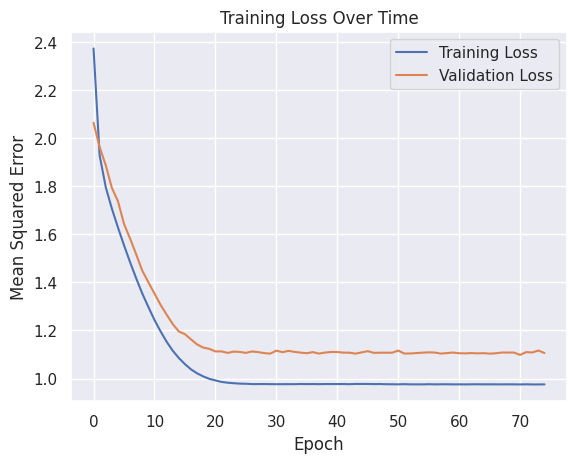

In [ ]:
#Adjusted Epochs again
# Load data
df_train = pd.read_csv('training_normalized_e.csv')
X_train = df_train.drop(['Yield_hg/ha', 'country'], axis=1)
y_train = df_train['Yield_hg/ha']

df_test = pd.read_csv('test_normalized_e.csv')
X_test = df_test.drop(['Yield_hg/ha', 'country'], axis=1)
y_test = df_test['Yield_hg/ha']

# Standardize the data so they have a mean of 0 and SD is 1 (z-score normalization)
#This is to help get our MSE to where we want it
numeric_cols = X_train.select_dtypes(include=['float64']).columns
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols]) #Fit
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols]) #Here we are going to transform test data using the same scaler

#Build the model with L2 regularization and a higher initial learning rate.
#Our validation loss was not learning fast enough, so we included regularization to help speed up the learning at initiation.
#Additional layers are included to help with the neural network complexity
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(X_train.shape[1],)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.Dense(32, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(0.01)))

#Compile the model and use the Adam optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

#Train our model
history = model.fit(X_train, y_train, epochs=75, batch_size=64, validation_split=0.2)

#Evaluate our model
predictions = model.predict(X_test)

#MSE calculations
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

#Visual
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()


Switching from MSE -> RMSE FINAL MODEL

Epoch 1/75
405/405 [==============================] - 2s 3ms/step - loss: 2.9429 - root_mean_squared_error: 1.3371 - val_loss: 2.1185 - val_root_mean_squared_error: 1.0514
Epoch 2/75
405/405 [==============================] - 1s 3ms/step - loss: 2.1627 - root_mean_squared_error: 1.0891 - val_loss: 2.0376 - val_root_mean_squared_error: 1.0469
Epoch 3/75
405/405 [==============================] - 1s 3ms/step - loss: 1.9461 - root_mean_squared_error: 1.0183 - val_loss: 1.9804 - val_root_mean_squared_error: 1.0503
Epoch 4/75
405/405 [==============================] - 1s 3ms/step - loss: 1.8382 - root_mean_squared_error: 0.9964 - val_loss: 1.9103 - val_root_mean_squared_error: 1.0471
Epoch 5/75
405/405 [==============================] - 1s 3ms/step - loss: 1.7622 - root_mean_squared_error: 0.9893 - val_loss: 1.8696 - val_root_mean_squared_error: 1.0570
Epoch 6/75
405/405 [==============================] - 1s 3ms/step - loss: 1.6984 - root_mean_squared_error: 0.9884 - val_loss: 1.7947 - val_

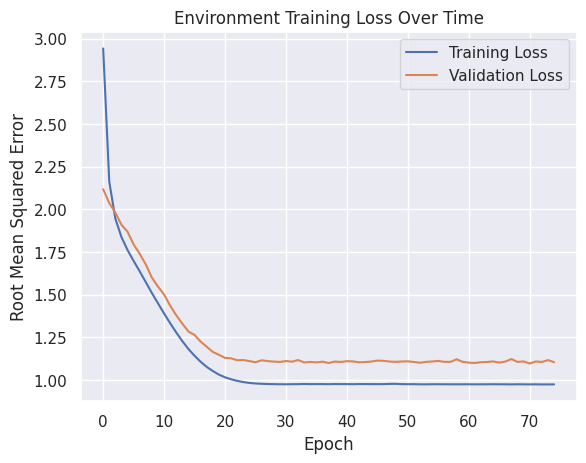

In [ ]:
# Load data
df_train = pd.read_csv('training_normalized_e.csv')
X_train = df_train.drop(['Yield_hg/ha', 'country'], axis=1)
y_train = df_train['Yield_hg/ha']

df_test = pd.read_csv('test_normalized_e.csv')
X_test = df_test.drop(['Yield_hg/ha', 'country'], axis=1)
y_test = df_test['Yield_hg/ha']

# Standardize the data so they have a mean of 0 and SD is 1 (z-score normalization)
numeric_cols = X_train.select_dtypes(include=['float64']).columns
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Build the model with L2 regularization and a higher initial learning rate.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(X_train.shape[1],)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.Dense(32, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(0.01)))

# Compile the model and use the Adam optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()]) #RMSE

# Train the model
history = model.fit(X_train, y_train, epochs=75, batch_size=64, validation_split=0.2)

# Evaluate the model
predictions = model.predict(X_test)

# Get RMSE from the metrics
rmse = np.sqrt(history.history['root_mean_squared_error'][-1])
print(f"Final Root Mean Squared Error: {rmse}")

# Visualize training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Squared Error')
plt.title('Environment Training Loss Over Time')
plt.legend()
plt.show()


In [ ]:
final_rmse = 0.993767689001647
num_params = model.count_params()

data = {
    'Data': ['Environmental Data'],
    'Hidden Sizes': ['[128, 64, 32, 32, 1]'],
    'Activation': ['[relu, relu, relu, sigmoid, linear]'],
    'Optimizer': ['Adam'],
    'Learning Rate': [0.001],
    '# Parameters': [num_params],
    'Test RMSE': [final_rmse]
}

df = pd.DataFrame(data)
print(df.to_string(index=False))


              Data         Hidden Sizes                          Activation Optimizer  Learning Rate  # Parameters  Test RMSE
Environmental Data [128, 64, 32, 32, 1] [relu, relu, relu, sigmoid, linear]      Adam          0.001         13345   0.993768


Now looking at our **Geographic** data

Epoch 1/100
405/405 [==============================] - 3s 4ms/step - loss: 2.5509 - val_loss: 2.3448
Epoch 2/100
405/405 [==============================] - 2s 4ms/step - loss: 1.9483 - val_loss: 1.9605
Epoch 3/100
405/405 [==============================] - 2s 4ms/step - loss: 1.7757 - val_loss: 1.8411
Epoch 4/100
405/405 [==============================] - 2s 4ms/step - loss: 1.6398 - val_loss: 1.7074
Epoch 5/100
405/405 [==============================] - 2s 5ms/step - loss: 1.5257 - val_loss: 1.6236
Epoch 6/100
405/405 [==============================] - 2s 6ms/step - loss: 1.4265 - val_loss: 1.5060
Epoch 7/100
405/405 [==============================] - 2s 5ms/step - loss: 1.3396 - val_loss: 1.4342
Epoch 8/100
405/405 [==============================] - 2s 4ms/step - loss: 1.2655 - val_loss: 1.3624
Epoch 9/100
405/405 [==============================] - 2s 4ms/step - loss: 1.2018 - val_loss: 1.2961
Epoch 10/100
405/405 [==============================] - 2s 4ms/step - loss: 1.1487 - val_lo

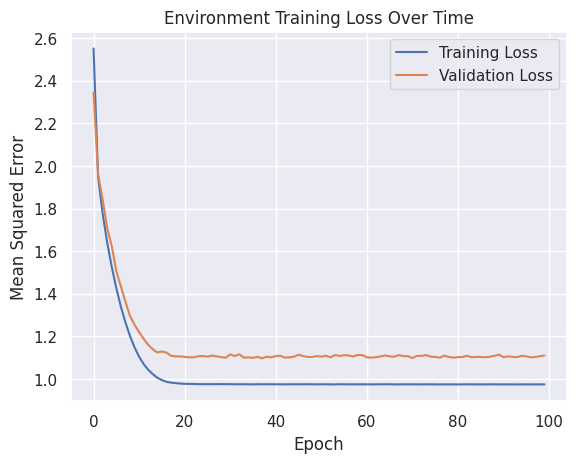

In [ ]:
#GEOGRAPHICAL DATA
# NORMALIZED TRAIN SET
df_train = pd.read_csv('training_normalized_g.csv') #Geographic data

# 'Yield_hg/ha' TARGET
X_train = df_train.drop(['Yield_hg/ha','country'], axis=1)
y_train = df_train['Yield_hg/ha']

X_train = X_train.fillna(0)

# NORMALIZED TEST SET
df_test = pd.read_csv('test_normalized_g.csv')

# 'Yield_hg/ha' TARGET
X_test = df_test.drop(['Yield_hg/ha','country'], axis=1)
y_test = df_test['Yield_hg/ha']

X_test= X_test.fillna(0)

# Standardize the data so they have a mean of 0 and SD is 1 (z-score normalization)
#This is to help get our MSE to where we want it
numeric_cols = X_train.select_dtypes(include=['float64']).columns
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

#Build the model with L2 regularization and a higher initial learning rate.
#Our validation loss was not learning fast enough, so we included regularization to help speed up the learning at initiation.
#Additional layers are included to help with the neural network complexity
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(X_train.shape[1],)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.Dense(32, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(0.01)))

#Compile the model and use the Adam optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

#Train our model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)

#Evaluate our model
predictions = model.predict(X_test)

#MSE calculations
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

#Visual
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Environment Training Loss Over Time')
plt.legend()
plt.show()


Switching from MSE -> RMSE **FINAL MODEL**

Epoch 1/100
405/405 [==============================] - 3s 4ms/step - loss: 2.8189 - root_mean_squared_error: 1.2038 - val_loss: 2.2140 - val_root_mean_squared_error: 1.0568
Epoch 2/100
405/405 [==============================] - 2s 5ms/step - loss: 2.0743 - root_mean_squared_error: 1.0227 - val_loss: 2.0621 - val_root_mean_squared_error: 1.0478
Epoch 3/100
405/405 [==============================] - 2s 4ms/step - loss: 1.8932 - root_mean_squared_error: 0.9943 - val_loss: 1.9522 - val_root_mean_squared_error: 1.0514
Epoch 4/100
405/405 [==============================] - 2s 4ms/step - loss: 1.7723 - root_mean_squared_error: 0.9902 - val_loss: 1.8406 - val_root_mean_squared_error: 1.0499
Epoch 5/100
405/405 [==============================] - 2s 4ms/step - loss: 1.6638 - root_mean_squared_error: 0.9883 - val_loss: 1.7583 - val_root_mean_squared_error: 1.0590
Epoch 6/100
405/405 [==============================] - 2s 5ms/step - loss: 1.5659 - root_mean_squared_error: 0.9879 - val_loss: 1.6441 

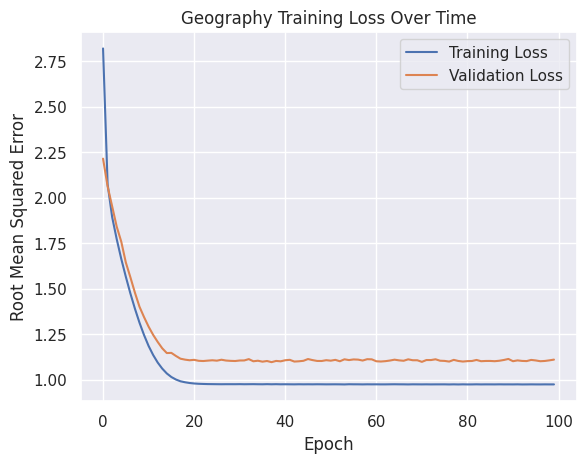

In [ ]:
# 'Yield_hg/ha' TARGET
X_train = df_train.drop(['Yield_hg/ha','country'], axis=1)
y_train = df_train['Yield_hg/ha']

X_train = X_train.fillna(0)

# NORMALIZED TEST SET
df_test = pd.read_csv('test_normalized_g.csv')

# 'Yield_hg/ha' TARGET
X_test = df_test.drop(['Yield_hg/ha','country'], axis=1)
y_test = df_test['Yield_hg/ha']

X_test= X_test.fillna(0)

# Standardize the data so they have a mean of 0 and SD is 1 (z-score normalization)
numeric_cols = X_train.select_dtypes(include=['float64']).columns
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Build the model with L2 regularization and a higher initial learning rate.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(X_train.shape[1],)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.Dense(32, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(0.01)))

# Compile the model and use the Adam optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()]) #RMSE

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)

# Evaluate the model
predictions = model.predict(X_test)

# Get RMSE from the metrics
rmse = np.sqrt(history.history['root_mean_squared_error'][-1])
print(f"Final Root Mean Squared Error: {rmse}")

# Visualize training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Squared Error')
plt.title('Geography Training Loss Over Time')
plt.legend()
plt.show()


In [ ]:
final_rmse = 0.99363158858084
num_params = model.count_params()

data = {
    'Data': ['Geographical Data'],
    'Hidden Sizes': ['[128, 64, 32, 32, 1]'],
    'Activation': ['[relu, relu, relu, sigmoid, linear]'],
    'Optimizer': ['Adam'],
    'Learning Rate': [0.001],
    '# Parameters': [num_params],
    'Test RMSE': [final_rmse]
}

df = pd.DataFrame(data)
print(df.to_string(index=False))


             Data         Hidden Sizes                          Activation Optimizer  Learning Rate  # Parameters  Test RMSE
Geographical Data [128, 64, 32, 32, 1] [relu, relu, relu, sigmoid, linear]      Adam          0.001         49057   0.993632


World Map

In [ ]:
import geopandas as gpd

<ipython-input-231-131b498392fb>:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


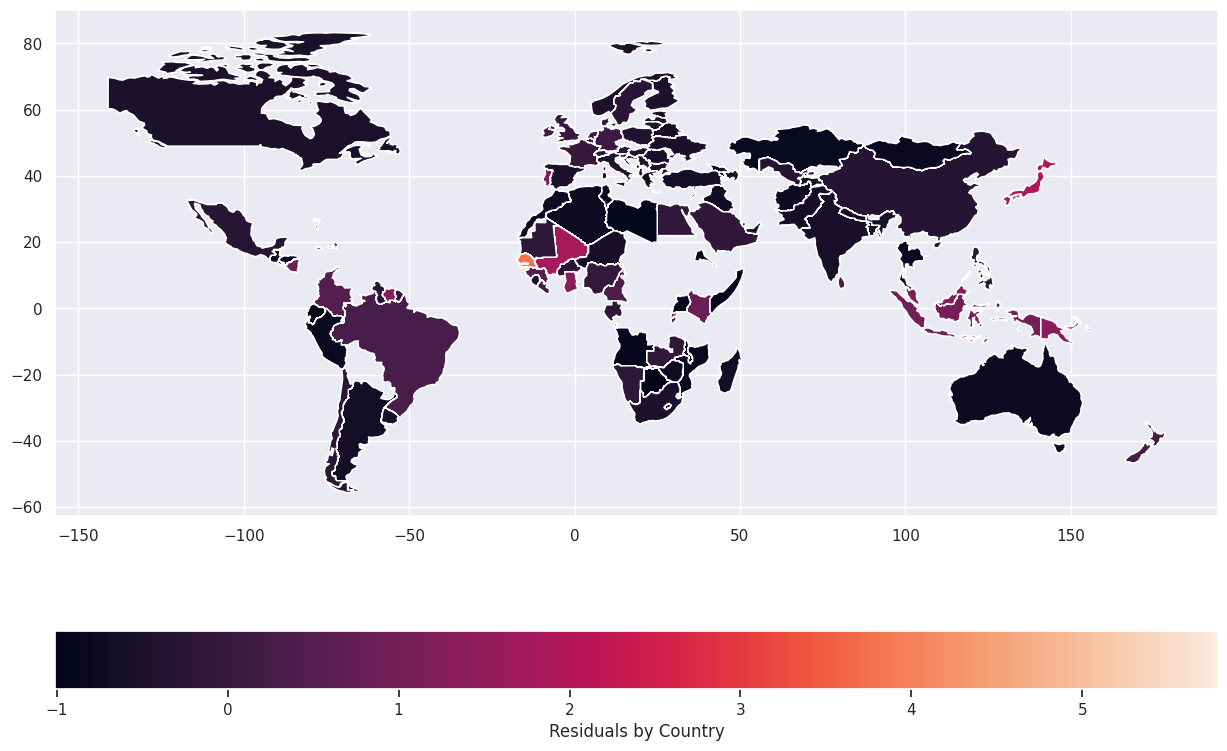

In [ ]:
#Here we are taking our test data and looking into country and predictions to see how well the model is doing
#Calculating the erros
df_test['residuals'] = df_test['Yield_hg/ha'] - predictions.flatten()

#Creating the geopandas DF map using https://geopandas.org/en/stable/docs.html guide
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#Here we merg the test data with the geopandas DF and then make sure that our countries match the world DF
merged = world.set_index('name').join(df_test.set_index('country'))

#Visual!
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged.plot(column='residuals', ax=ax, legend=True, legend_kwds={'label': "Residuals by Country", 'orientation': "horizontal"})
plt.show()


In [ ]:
#Using the test data, calculating the residuals
df_test['residuals'] = df_test['Yield_hg/ha'] - predictions.flatten()

#We are grouping country and calculating mean residual for each country
residuals_by_country = df_test.groupby('country')['residuals'].mean().reset_index()

#Sorting by top15 residuals
residuals_by_country_sorted_desc = residuals_by_country.sort_values(by='residuals', ascending=False).head(15)

#Sorting by bottom15 residuals
residuals_by_country_sorted_asc = residuals_by_country.sort_values(by='residuals', ascending=True).head(15)

#Results
print("Top 15 Countries with Highest Residuals:")
print(residuals_by_country_sorted_desc)
print("\nTop 15 Countries with Lowest Residuals:")
print(residuals_by_country_sorted_asc)


Top 15 Countries with Highest Residuals:
                  country  residuals
110        United Kingdom   2.262943
13                Belgium   1.988982
75            Netherlands   1.941217
50                Ireland   1.756497
76            New Zealand   1.674039
26                Denmark   1.640809
10                Bahrain   1.541362
101                Sweden   1.518020
109  United Arab Emirates   1.379393
38                Germany   1.080805
34                Finland   1.050652
102           Switzerland   1.029055
80                 Norway   0.939844
100              Suriname   0.816981
52                Jamaica   0.783393

Top 15 Countries with Lowest Residuals:
                      country  residuals
14                   Botswana  -0.948606
32                    Eritrea  -0.886798
21   Central African Republic  -0.643803
94                  Singapore  -0.611909
66                 Mauritania  -0.608629
107                    Uganda  -0.582890
28                    Ecuador  -0.57938